# Main

This notebooks reproduces the results from the paper, implementing the classic version of the spin system.


## I. Basic imports and setup

In [1]:
import numpy as np
from numpy import empty, nan, savetxt
from datetime import datetime
import matplotlib.pyplot as plt
import random

from source.spinsystem import SpinSystem
from source.utils import read_config_file, reconstruct_grid, visualize_grid, plot_array_list

from statsmodels.tsa.stattools import acf

In [2]:
MAX_FILE_SIZE = 100_000

config_filename = "multising.conf"
config = read_config_file(config_filename)

In [3]:
# fix seed
SEED = 42
random.seed(SEED)       
np.random.seed(SEED)  

# parameters
grid_height = int(config["grid_height"])
grid_width  = int(config["grid_width"])
alpha       = float(config["alpha"])
j           = float(config["j"])
total_updates = int(config["total_updates"])
init_up     = float(config["init_up"])
T           = float(config["T"])
beta        = 1/T

reduced_alpha              = -2 * beta * alpha
reduced_neighbour_coupling = -2 * beta * j

magnetisation = empty((min(total_updates, MAX_FILE_SIZE), ), dtype=float)
magnetisation[:] = nan

# initiate the system
spin_system = SpinSystem(
    grid_height=grid_height,
    grid_width=grid_width,
    init_up=init_up
)

full_grids = []
full_grids.append(reconstruct_grid(spin_system.black, spin_system.white))

## II. Experiments

### A. Evolution of spin system over time

In [4]:
for ii in range(total_updates):
    # update
    mag = spin_system.update(reduced_neighbour_coupling, reduced_alpha)
    full_grids.append(reconstruct_grid(spin_system.black, spin_system.white))
    magnetisation[ii % MAX_FILE_SIZE] = mag

    if ii > 0 and (ii % MAX_FILE_SIZE == 0):
        savetxt(f"magnetisation_{ii}.dat", magnetisation)
        magnetisation[:] = nan

savetxt(f"magnetisation_{ii}.dat", magnetisation)

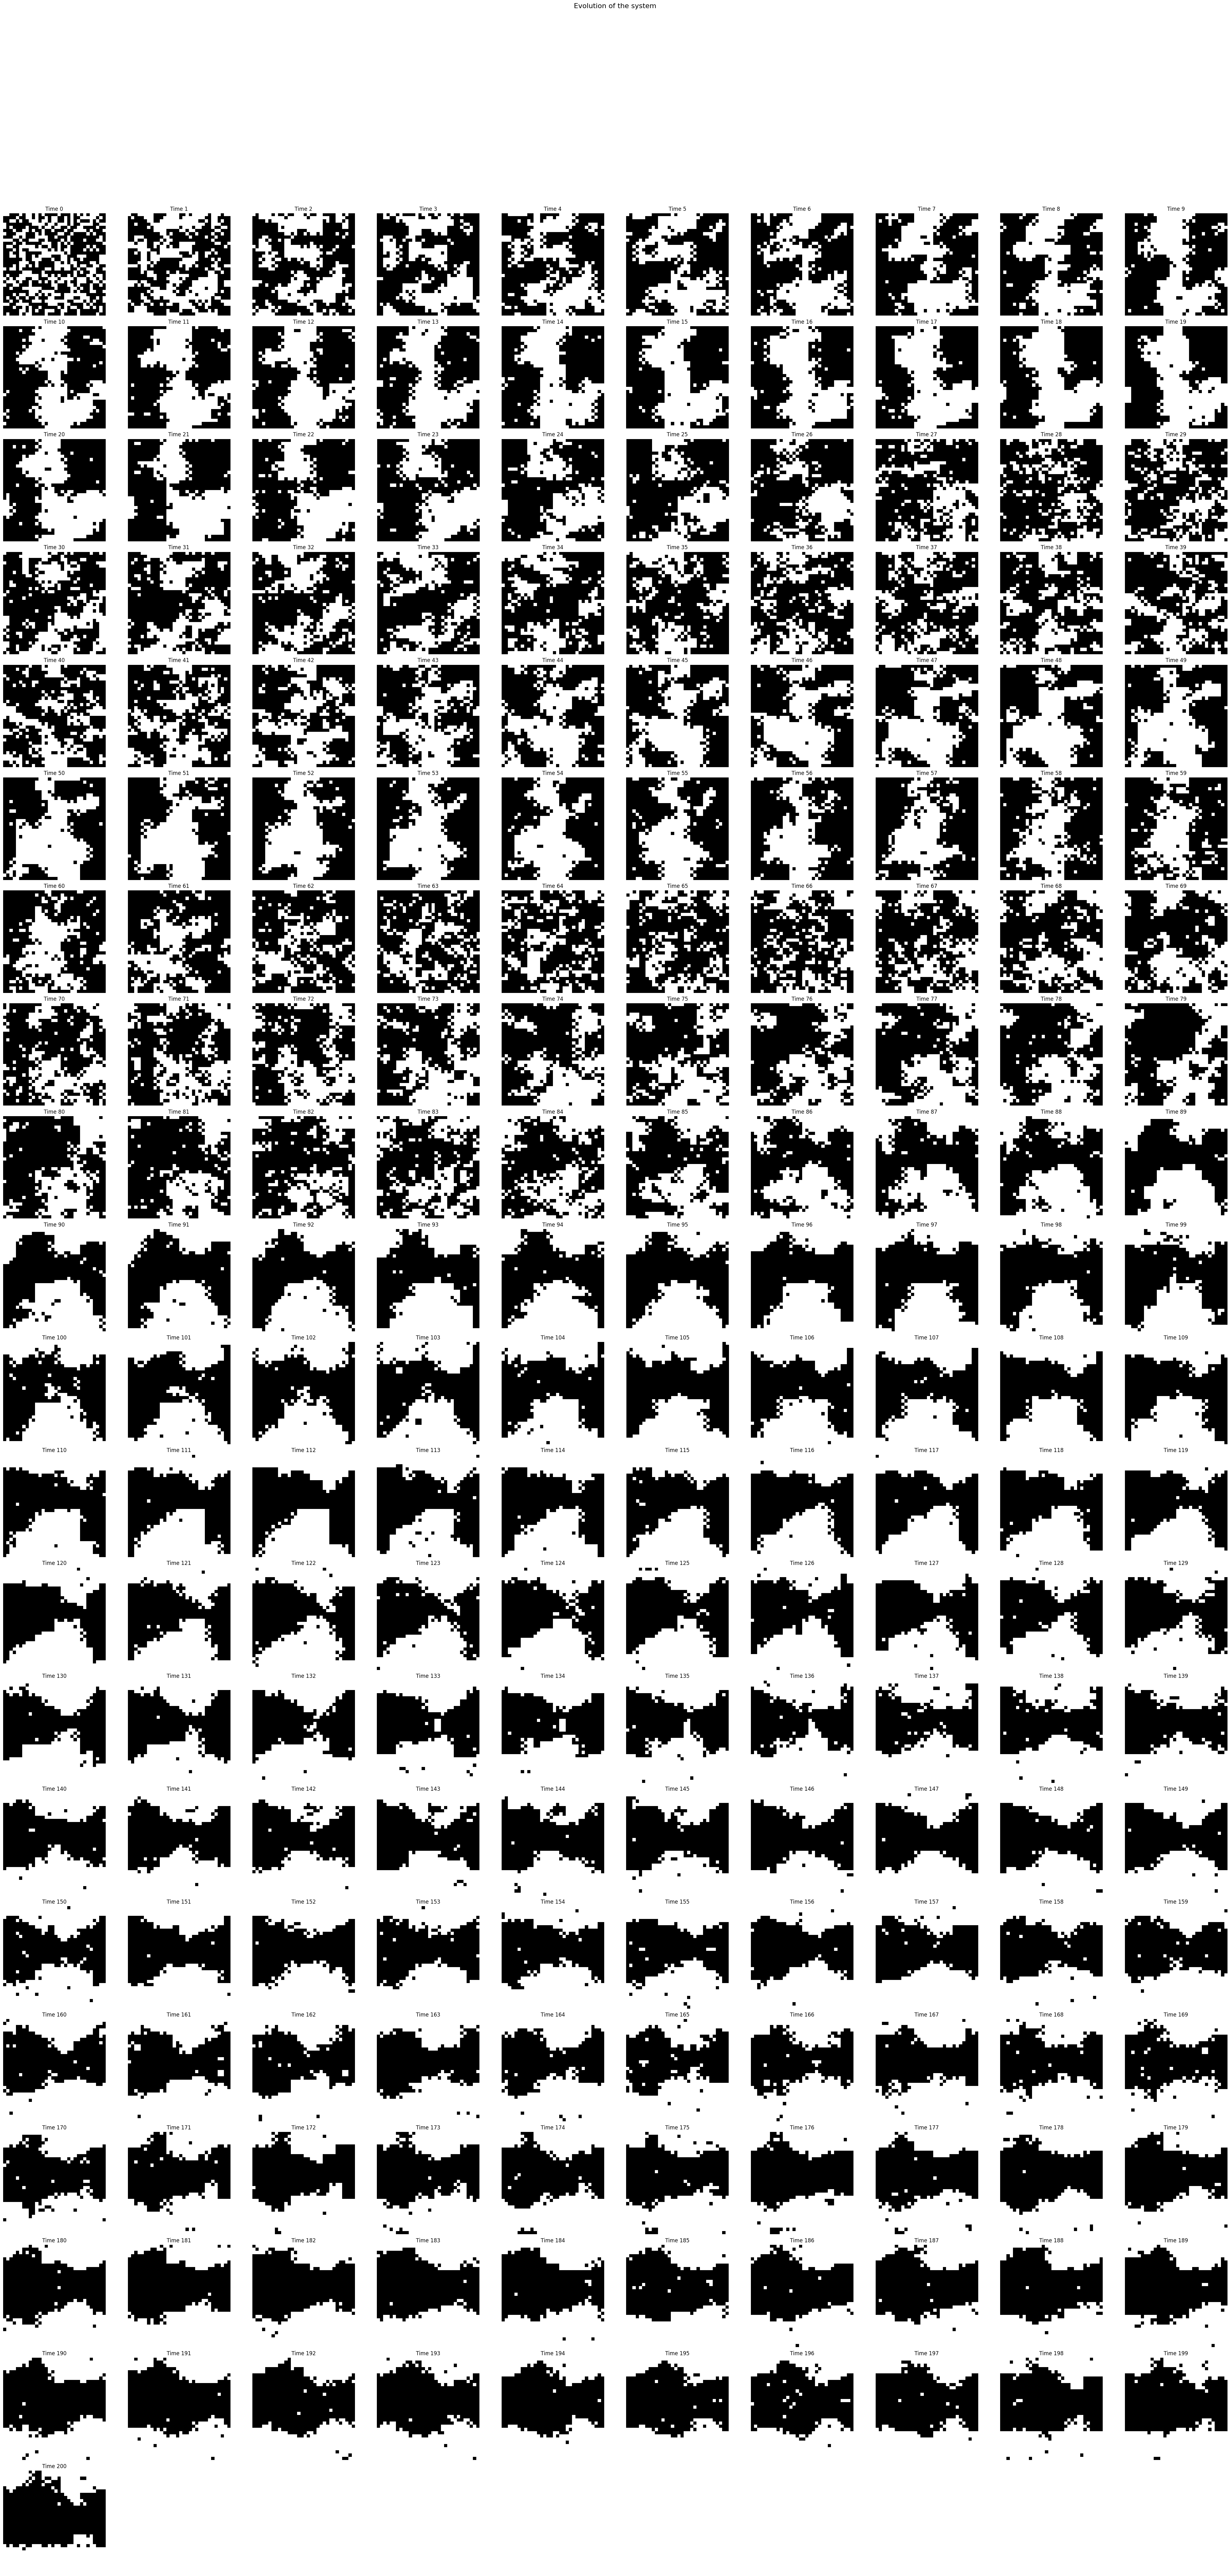

In [5]:
plot_array_list(full_grids, max_cols=10)

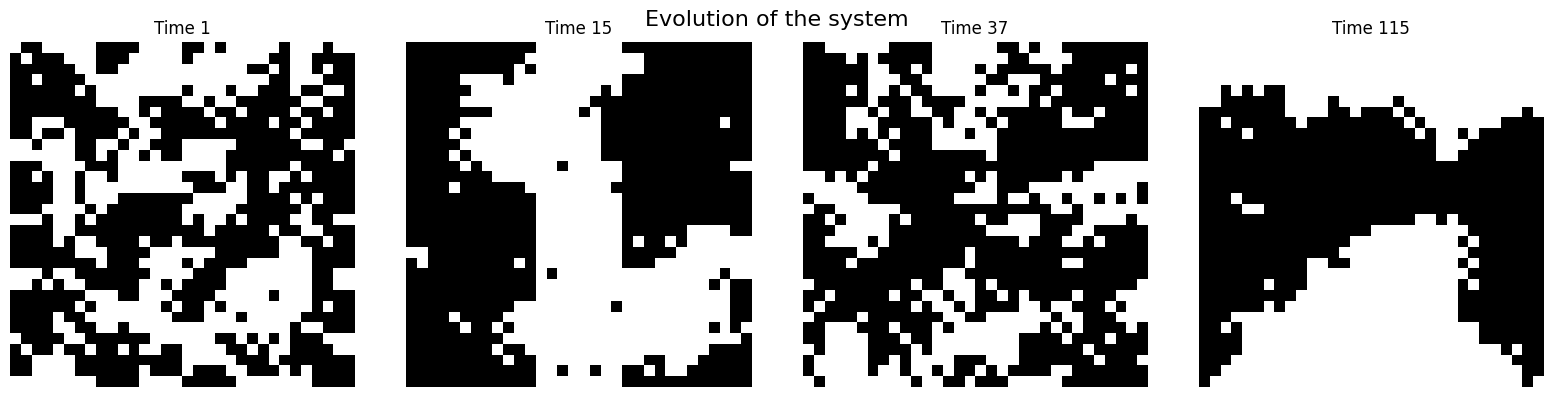

In [6]:
plot_array_list(np.array([full_grids[1], full_grids[15], full_grids[37], full_grids[115]]), max_cols=5, timesteps=[1,15,37,115])

### B. Evolution of the spin system characteristics

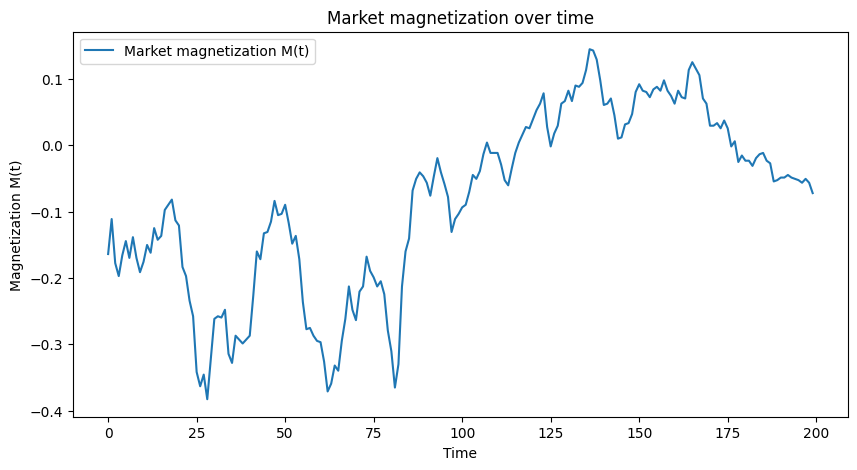

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(magnetisation, label="Market magnetization M(t)")
plt.xlabel("Time")
plt.ylabel("Magnetization M(t)")
plt.title("Market magnetization over time")
plt.legend()
plt.show()


Text(0.5, 1.0, 'Market returns over time')

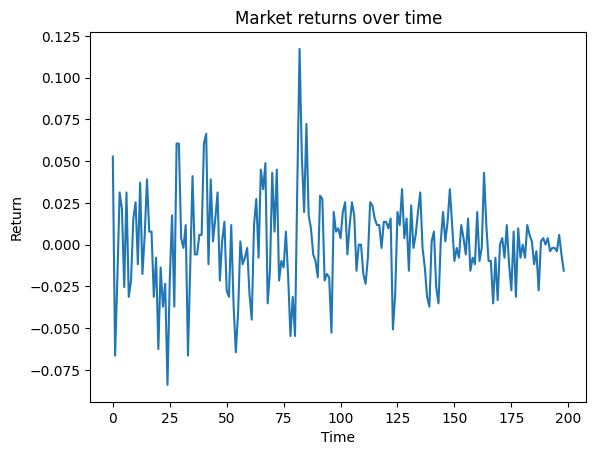

In [8]:
market_returns = np.diff(magnetisation)
plt.plot(market_returns)
plt.xlabel("Time")
plt.ylabel("Return")
plt.title("Market returns over time")

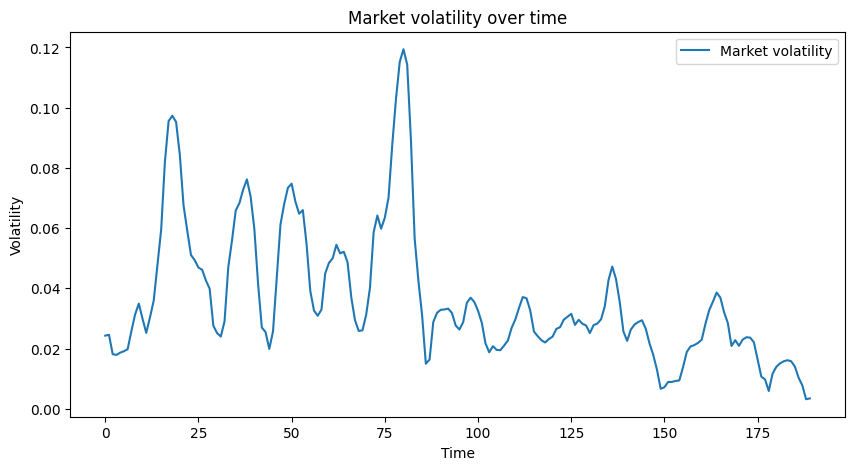

In [9]:
window_size = 10  
volatility = [np.std(magnetisation[i:i+window_size]) for i in range(len(magnetisation)-window_size)]

plt.figure(figsize=(10, 5))
plt.plot(volatility, label="Market volatility")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.title("Market volatility over time")
plt.legend()
plt.show()


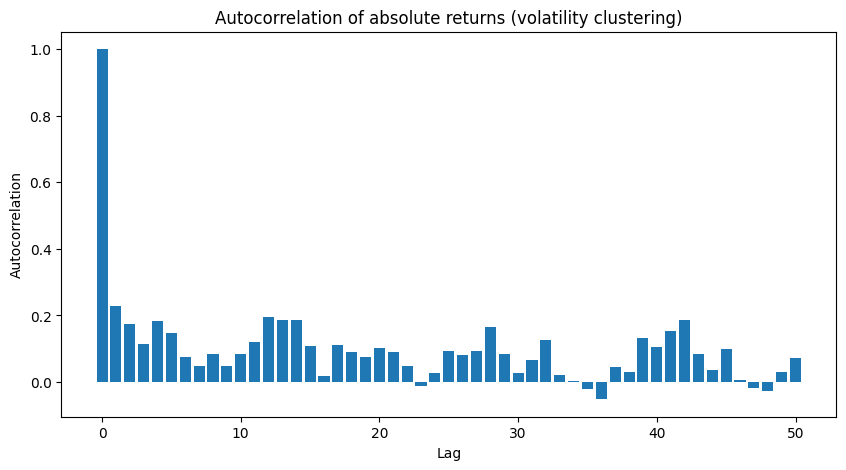

In [10]:
abs_returns = np.abs(market_returns)

autocorr_volatility = acf(abs_returns, nlags=50)

plt.figure(figsize=(10, 5))
plt.bar(range(len(autocorr_volatility)), autocorr_volatility)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of absolute returns (volatility clustering)")
plt.show()
